[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Praanshu101/Data_Validation/blob/main/Lab2.ipynb)

#### Team members (Team 21):

Praanshu Patel (23110249)

Rishank Soni (23110277)

### Dataset Preparation

In [1]:
# Extraction of the data from the zip file (To be run in Google Colab)

import os
import zipfile

if not os.path.exists("/202412-citibike-tripdata"):
  !wget https://s3.amazonaws.com/tripdata/202412-citibike-tripdata.zip

zip_file_path = '/content/202412-citibike-tripdata.zip'
extraction_folder = '/202412-citibike-tripdata'

# Create the extraction folder
os.makedirs(extraction_folder, exist_ok=True)

# Extract into the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract('202412-citibike-tripdata_1.csv', path=extraction_folder)


--2025-02-07 14:07:34--  https://s3.amazonaws.com/tripdata/202412-citibike-tripdata.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.219.96, 52.216.212.200, 52.217.136.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.219.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450888449 (430M) [application/zip]
Saving to: ‘202412-citibike-tripdata.zip’

                202  19%[==>                 ]  83.24M  1.18MB/s    eta 5m 28s 

OSError: [Errno 5] Input/output error

In [2]:
!pip install pandera -q # (To be run in Google Colab)

In [5]:
import pandas as pd
import pandera as pa
import json

import os
import zipfile
import warnings

warnings.filterwarnings('ignore')

In [6]:
# Load the csv files from folder 202412-citibike-tripdata

path = '/202412-citibike-tripdata'
files = os.listdir(path)

# Load the csv files into a dataframe
df = pd.concat([pd.read_csv(path + '/' + f) for f in files], ignore_index = True)

# Display the first 5 rows of the dataframe
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/202412-citibike-tripdata'

#### Validation of key fields

Validating the following fields (using pandera):
- ride_id (string)
- rideable_type (categorical)
- started_at (string)
- ended_at (string)
- start_station_name (string)
- start_station_id (string)
- end_station_name (string)
- end_station_id (string)
- start_lat, start_lng (float)
- end_lat, end_lng (float)
- member_casual (categorical)

In [ ]:
# Original dataframe columns and data types

df.dtypes

##### Q1 a) Validating the datatype of each column

In [ ]:
# Validating the schema of the dataframe (data types of the columns)

schema = pa.DataFrameSchema({
    "ride_id": pa.Column(pa.String),
    "rideable_type": pa.Column(pa.String),
    "started_at": pa.Column(pa.String),
    "ended_at": pa.Column(pa.String),
    "start_station_name": pa.Column(pa.String),
    "start_station_id": pa.Column(pa.String),
    "end_station_name": pa.Column(pa.String),
    "end_station_id": pa.Column(pa.String),
    "start_lat": pa.Column(pa.Float),
    "start_lng": pa.Column(pa.Float),
    "end_lat": pa.Column(pa.Float),
    "end_lng": pa.Column(pa.Float),
    "member_casual": pa.Column(pa.String)
})

try:
    schema.validate(df, lazy=True)
except pa.errors.SchemaErrors as e:
    print(json.dumps(e.message, indent=2))

Fixing the datatypes and errors:

In [ ]:
# Converting the start_station_id and end_station_id to string
df['start_station_id'] = df['start_station_id'].astype(str)
df['end_station_id'] = df['end_station_id'].astype(str)

# Validate the schema of the dataframe
try:
    schema.validate(df, lazy=True)
    print("The dataframe is valid")
except pa.errors.SchemaErrors as e:
    print(json.dumps(e.message, indent=2))


##### Q1 b) Analyzing features and writing appropriate checks

In [ ]:
# Analyzing each feature

# Rideaable type (only two types of rideable type)
print(df['rideable_type'].value_counts())

# Member_casual (only two types of member_casual)
print(df['member_casual'].value_counts())

# Checking if the start_station_id and end_station_id are the same
print("Number of rows with same start_station_id and end_station_id:")
print(df[df['start_station_id'] == df['end_station_id']].shape[0])

# Checking the range of latitude and longitude
print("Number of rows with latitude and longitude out of range:")
print(df[(df['start_lat'] > 90) | (df['start_lat'] < -90)].shape[0])
print(df[(df['start_lng'] > 180) | (df['start_lng'] < -180)].shape[0])
print(df[(df['end_lat'] > 90) | (df['end_lat'] < -90)].shape[0])
print(df[(df['end_lng'] > 180) | (df['end_lng'] < -180)].shape[0])

# Checking if the start_lat, start_lng and end_lat, end_lng are same
print("Number of rows with same start_lat and start_lng:")
print(df[(df['start_lat'] == df['end_lat']) & (df['start_lng'] == df['end_lng'])].shape[0])

# Checking if the start_time is greater than end_time
print("Number of rows with start_time greater than end_time:")
print(df[df['started_at'] > df['ended_at']].shape[0])

Validating using a schema:

In [ ]:
# Validating the above checks using schema

schema2 = pa.DataFrameSchema({
    "ride_id": pa.Column(pa.String),
    "rideable_type": pa.Column(pa.String, checks=[pa.Check.isin(["classic_bike", "electric_bike"])]),
    "started_at": pa.Column(pa.String),
    "ended_at": pa.Column(pa.String),
    "start_station_name": pa.Column(pa.String),
    "start_station_id": pa.Column(pa.String),
    "end_station_name": pa.Column(pa.String),
    "end_station_id": pa.Column(pa.String),
    "start_lat": pa.Column(pa.Float, checks=[pa.Check.greater_than(-90), pa.Check.less_than(90)]),
    "start_lng": pa.Column(pa.Float, checks=[pa.Check.greater_than(-180), pa.Check.less_than(180)]),
    "end_lat": pa.Column(pa.Float, checks=[pa.Check.greater_than(-90), pa.Check.less_than(90)]),
    "end_lng": pa.Column(pa.Float, checks=[pa.Check.greater_than(-180), pa.Check.less_than(180)]),
    "member_casual": pa.Column(pa.String, checks=[pa.Check.isin(["member", "casual"])])
})

try:
    schema2.validate(df, lazy=True)
    print("The data is valid")
except pa.errors.SchemaErrors as e:
    print(json.dumps(e.message, indent=2))


##### Q1 c) Adding data validation rules to verify that start time is lesser than end time (Using Pandera Decorators)

In [ ]:
# Validate if the start_time is lesser than end_time using pandera decorators

# Defining the schema for the output of the function (time column should be greater than or equal to 0)
schema3 = pa.DataFrameSchema({
    'time': pa.Column(pa.Float, checks=[pa.Check.ge(0)], nullable=False)
})

@pa.check_output(schema3) # To Validate the output of the function

def validate_schema(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the started_at and ended_at to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Calculate the time taken for the ride
    df['time'] = (df['ended_at'] - df['started_at']).dt.total_seconds().astype(float)

    return df

# Validate the schema of the dataframe
df3 = validate_schema(df)
try:
    schema3.validate(df3, lazy=True)
    print("The data is valid")
except pa.errors.SchemaErrors as e:
    print(json.dumps(e.message, indent=2))

Q2
a)
Validate the datatype of each column using Great Expectations

In [ ]:
# Remove any existing great_expectations directory
!rm -rf gx

# Install great_expectations
!pip install great_expectations -q

In [ ]:
# Initialize the data context
import great_expectations as gx
from great_expectations.data_context.types.base import DataContextConfig
from great_expectations.checkpoint import CheckpointResult

import pandas as pd

In [ ]:


# Get the Great Expectations context in file mode
context = gx.get_context(mode="file")

# Add a new data source for pandas dataframes
data_source_name = "my_data_source"
data_source = context.data_sources.add_pandas(name=data_source_name)

# Add a new data asset to the data source
data_asset_name = "my_dataframe_data_asset"
data_asset = data_source.add_dataframe_asset(name=data_asset_name)

# Define a batch for the whole dataframe
batch_definition = data_asset.add_batch_definition_whole_dataframe("batch definition")

# Set the batch parameters with the dataframe
batch_parameters = {"dataframe": df}

# Get the batch using the batch definition and parameters
batch = batch_definition.get_batch(batch_parameters)
print(batch.head(4))

In [ ]:
# Create an expectation suite
suite_name = "datatype_validation_suite"
suite = gx.ExpectationSuite(name=suite_name)
context.suites.add(suite)

In [ ]:
# Add expectations to the suite
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="ride_id", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeInSet(
        column="rideable_type", value_set=["electric_bike", "classic_bike"]
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="started_at", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="ended_at", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="start_station_name", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="start_station_id", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="end_station_name", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="end_station_id", type_="str"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="start_lat", type_="float"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="start_lng", type_="float"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="end_lat", type_="float"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeOfType(
        column="end_lng", type_="float"
    )
)
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToBeInSet(
        column="member_casual", value_set=["member", "casual"]
    )
)





In [ ]:
# define the validation definition with the batch definition and suite
definition_name = "my_validation_definition"
validation_definition = gx.ValidationDefinition(
    data=batch_definition, suite=suite, name=definition_name
)
validation_definition = context.validation_definitions.add(validation_definition) # Add the validation definition to the context

In [ ]:
validation_definition_name = "my_validation_definition"
validation_definition = context.validation_definitions.get(validation_definition_name) # Get the validation definition from the context

validation_results = validation_definition.run(batch_parameters=batch_parameters)
print(validation_results)




### Validation Results


The validation results for the dataset are as follows:

- **Total Expectations Evaluated**: 13
- **Successful Expectations**: 11
- **Unsuccessful Expectations**: 2


#### Successful Expectations:
1. `expect_column_values_to_be_of_type` for column `ride_id`
2. `expect_column_values_to_be_in_set` for column `rideable_type`
3. `expect_column_values_to_be_of_type` for column `start_station_name`
4. `expect_column_values_to_be_of_type` for column `start_station_id`
5. `expect_column_values_to_be_of_type` for column `end_station_name`
6. `expect_column_values_to_be_of_type` for column `end_station_id`
7. `expect_column_values_to_be_of_type` for column `start_lat`
8. `expect_column_values_to_be_of_type` for column `start_lng`
9. `expect_column_values_to_be_of_type` for column `end_lat`
10. `expect_column_values_to_be_of_type` for column `end_lng`
11. `expect_column_values_to_be_in_set` for column `member_casual`

#### Unsuccessful Expectations:
1. `expect_column_values_to_be_of_type` for column `started_at` (Expected: `str`, Observed: `datetime64`)
2. `expect_column_values_to_be_of_type` for column `ended_at` (Expected: `str`, Observed: `datetime64`)

The validation was partially successful with a majority of the expectations being met. However, there were issues with the data types of the `started_at` and `ended_at` columns, which were expected to be strings but were observed as datetime objects.

Q2. b) A mail when encountering a failure

In [ ]:
# impot the actions from great_expectations
from great_expectations.checkpoint import (EmailAction)

In [ ]:
context = gx.get_context()
validation_definitions = [
    context.validation_definitions.get("my_validation_definition")
]

In [ ]:
email_action =[EmailAction(
    name="send_email_on_failure",
    smtp_address='smtp.gmail.com',
    smtp_port=587, # 587 is the default port for TLS
    receiver_emails="23110249@iitgn.ac.in", # Receiver email
    sender_login="23110277@iitgn.ac.in", # Sender email
    #password = ""
    use_tls=True,
    notify_on="failure"# Notify on all results
)]

In [ ]:
checkpoint_name = "my_checkpoint"
checkpoint = gx.Checkpoint(
    name=checkpoint_name,
    validation_definitions=validation_definitions, # List of ValidationDefinition objects
    actions=email_action, # List of Action objects
    result_format={"result_format": "COMPLETE"},
)

# Save the Checkpoint to the Data Context
context.checkpoints.add(checkpoint)

# Retrieve the Checkpoint later
checkpoint_name = "my_checkpoint"
checkpoint = context.checkpoints.get(checkpoint_name)

In [ ]:
# Run the Check and send the results to the email action
validation_results = checkpoint.run(
    batch_parameters=batch_parameters, expectation_parameters=suite
)

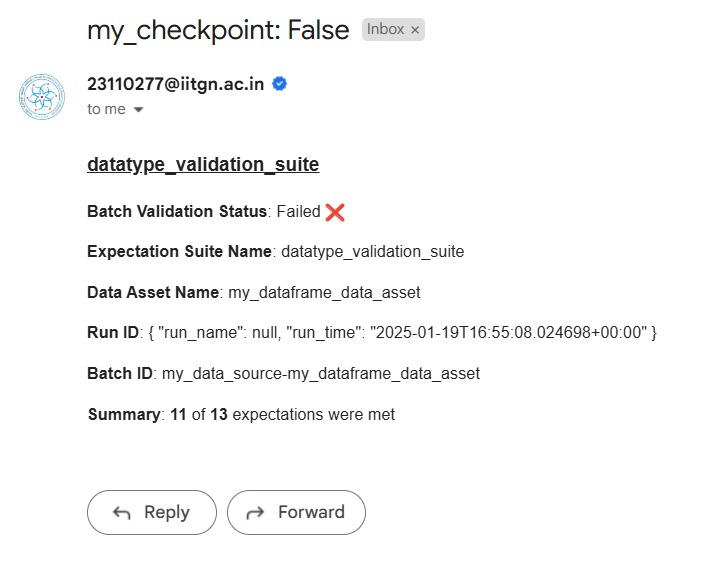